In [7]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='dask.config')

# --- GPU Detection ---
import subprocess
try:
    gpu_info = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader']
    )
    print(f"GPUs Detected:\n{gpu_info.decode('utf-8').strip()}")
    GPU_AVAILABLE = True
except Exception as e:
    print(f"No GPU detected. Running on CPU.\n{e}")
    GPU_AVAILABLE = False
try:
    import cupy as cp
    import dask.array as da
    from dask_cuda import LocalCUDACluster
    from dask.distributed import Client

    RAPIDS_AVAILABLE = True
    print("CuPy + Dask-CUDA backend enabled")
    
    # Start a CUDA cluster that can use both T4 GPUs
    cluster = LocalCUDACluster()
    CLIENT = Client(cluster)
    print(f"Dask Dashboard: {CLIENT.dashboard_link}\n")

except Exception as e:
    print("RAPIDS/cuDF/cuML not fully available. Falling back to CPU/Dask backend.")
    from dask.distributed import Client
    CLIENT = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
    RAPIDS_AVAILABLE = False
    print(f"Dask Dashboard Link: {CLIENT.dashboard_link}\n")

# --- Backend Summary ---
if RAPIDS_AVAILABLE:
    from cuml.linear_model import LogisticRegression as cuLogReg
    from cuml.ensemble import RandomForestClassifier as cuRF
    from cuml.svm import SVC as cuSVC
    print("Using cuML GPU models\n")
else:
    print("Using sklearn CPU models\n")

# --- Import core packages (unchanged) ---
import dask.dataframe as dd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Dask-ML models
from dask_ml.linear_model import LogisticRegression
from dask_ml.preprocessing import StandardScaler

# sklearn models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    matthews_corrcoef, cohen_kappa_score
)
from dask.distributed import wait

GPUs Detected:
Tesla T4, 15360 MiB
Tesla T4, 15360 MiB
CuPy + Dask-CUDA backend enabled


/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46089 instead
  warnings.warn(


Dask Dashboard: http://127.0.0.1:46089/status

Using cuML GPU models



# Configuration Settings

In [8]:
train_dir = "/kaggle/input/magnetic-dataset/magnetic_data/train"
dev_dir = "/kaggle/input/magnetic-dataset/magnetic_data/dev"
CLIENT = Client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
print(f"Dask Dashboard Link: {CLIENT.dashboard_link}\n")

features = [
    'USFLUX_log', 'TOTPOT_log', 'PIL_LEN_log', 'MEANSHR', 'TOTFZ', 'EPSZ', 'R_VALUE',
    'USFLUX_log_roll_mean5', 'USFLUX_log_roll_std5', 'TOTPOT_log_diff1', 'MEANSHR_lag3'
]
target_col = 'label'
class_names = ['No Flare', 'C-Class', 'M-Class', 'X-Class']

/usr/local/lib/python3.11/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42461 instead
  warnings.warn(


Dask Dashboard Link: http://127.0.0.1:42461/status



## Data Loading and Preparation

In [9]:
def encode_binary_target(label):
    if isinstance(label, str) and any(label.startswith(c) for c in ['C', 'M', 'X']): return 1
    return 0

def encode_multiclass_target(label):
    if isinstance(label, str):
        if label.startswith('X'): return 3
        if label.startswith('M'): return 2
        if label.startswith('C'): return 1
    return 0

In [10]:
# --- Load and process TRAIN data ---
ddf_train = dd.read_parquet(train_dir)
ddf_train['y_binary'] = ddf_train[target_col].apply(encode_binary_target, meta=('y_binary', np.int8))
ddf_train['y_multiclass'] = ddf_train[target_col].apply(encode_multiclass_target, meta=('y_multiclass', np.int8))

X_train = ddf_train[features].to_dask_array()
y_train_binary = ddf_train['y_binary'].to_dask_array()
y_train_multiclass = ddf_train['y_multiclass'].to_dask_array()

X_train = X_train.compute_chunk_sizes()
y_train_binary = y_train_binary.compute_chunk_sizes()
y_train_multiclass = y_train_multiclass.compute_chunk_sizes()

# --- Load and process DEV data ---
ddf_dev = dd.read_parquet(dev_dir)
ddf_dev['y_binary'] = ddf_dev[target_col].apply(encode_binary_target, meta=('y_binary', np.int8))
ddf_dev['y_multiclass'] = ddf_dev[target_col].apply(encode_multiclass_target, meta=('y_multiclass', np.int8))

X_dev = ddf_dev[features].to_dask_array()
y_dev_binary = ddf_dev['y_binary'].to_dask_array()
y_dev_multiclass = ddf_dev['y_multiclass'].to_dask_array()

X_dev = X_dev.compute_chunk_sizes()
y_dev_binary = y_dev_binary.compute_chunk_sizes()
y_dev_multiclass = y_dev_multiclass.compute_chunk_sizes()

In [12]:
# --- Analyze Class Imbalance on the Training Set ---
print("--- Binary Class Analysis (Train Set) ---")
class_counts_binary = ddf_train['y_binary'].value_counts().compute()
flare_percentage = (class_counts_binary.get(1, 0) / class_counts_binary.sum()) * 100
print(f"Class Distribution:\n{class_counts_binary}")
print(f"Flare (Positive Class) Percentage: {flare_percentage:.2f}%\n")

print("--- Multiclass Analysis (Train Set) ---")
class_counts_multi = ddf_train['y_multiclass'].value_counts().compute()
print(f"Multiclass Distribution:\n{class_counts_multi}")
print("Note the mapping: 0=No Flare, 1=C-Class, 2=M-Class, 3=X-Class\n")

--- Binary Class Analysis (Train Set) ---
Class Distribution:
y_binary
1     1484580
0    11042520
Name: count, dtype: int64
Flare (Positive Class) Percentage: 11.85%

--- Multiclass Analysis (Train Set) ---
Multiclass Distribution:
y_multiclass
1     1234740
2      227100
3       22740
0    11042520
Name: count, dtype: int64
Note the mapping: 0=No Flare, 1=C-Class, 2=M-Class, 3=X-Class



## Feature Scaling and Normalization

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
    
# --- Create NumPy versions for Scikit-learn models ---
(X_train_scaled_np, y_train_binary_np, y_train_multiclass_np,
 X_dev_scaled_np, y_dev_binary_np, y_dev_multiclass_np) = da.compute(
    X_train_scaled, y_train_binary, y_train_multiclass,
    X_dev_scaled, y_dev_binary, y_dev_multiclass)

X_train_scaled = X_train_scaled.persist()
X_dev_scaled = X_dev_scaled.persist()
y_train_binary = y_train_binary.persist()
y_train_multiclass = y_train_multiclass.persist()
y_dev_binary = y_dev_binary.persist()
y_dev_multiclass = y_dev_multiclass.persist()

_ = wait([X_train_scaled, X_dev_scaled, y_train_binary, y_train_multiclass, y_dev_binary, y_dev_multiclass])

# Evaluation Function

In [14]:
# Helper to ensure compatibility
def to_numpy(x):
    import cupy as cp
    return x.get() if isinstance(x, cp.ndarray) else x

def _print_binary_report(y_true, y_pred, y_pred_proba, report_title):
    y_true = to_numpy(y_true)
    y_pred = to_numpy(y_pred)
    y_pred_proba = to_numpy(y_pred_proba)
    
    print(f"\n--- Metrics for: {report_title} ---")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Flare (0)', 'Flare (1)']))
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
    pr_auc = average_precision_score(y_true, y_pred_proba[:, 1])
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall (PR) AUC Score: {pr_auc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Matthews Corr. Coef (MCC): {mcc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Flare', 'Predicted Flare'], yticklabels=['Actual No Flare', 'Actual Flare'])
    plt.title(f'Confusion Matrix - {report_title}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [15]:

def _print_multiclass_report(y_true, y_pred, y_pred_proba, class_names, report_title):
    y_true = to_numpy(y_true)
    y_pred = to_numpy(y_pred)
    y_pred_proba = to_numpy(y_pred_proba)
    
    print(f"\n--- Metrics for: {report_title} ---")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    try:
        roc_auc = roc_auc_score(y_true, y_pred_proba, multi_class='ovr', average='weighted')
        print(f"Weighted ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
    except ValueError as e: print(f"Could not compute ROC AUC Score: {e}")
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Matthews Corr. Coef (MCC): {mcc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Predicted {c}' for c in class_names], yticklabels=[f'Actual {c}' for c in class_names])
    plt.title(f'Confusion Matrix - {report_title}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [16]:
def evaluate_on_sets(model, X_train, y_train, X_dev, y_dev, model_name, 
                     problem_type='binary', class_names=None):
    print(f"\n{'='*70}\nEVALUATING MODEL: {model_name}\n{'='*70}")
    
    # Check if inputs are Dask arrays
    is_dask_X_train = isinstance(X_train, da.Array)
    is_dask_y_train = isinstance(y_train, da.Array)
    is_dask_X_dev = isinstance(X_dev, da.Array)
    is_dask_y_dev = isinstance(y_dev, da.Array)

    # --- Evaluate on Training Set ---
    print(f"Predicting on training set...")
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)
    
    # Always compute Dask arrays to NumPy
    if is_dask_X_train or isinstance(y_pred_train, da.Array):
        print("Computing training predictions...")
        y_pred_train, y_proba_train = da.compute(y_pred_train, y_proba_train)
    
    if is_dask_y_train:
        print("Computing training labels...")
        y_true_train = y_train.compute()
    else:
        y_true_train = y_train
    
    # --- Evaluate on Validation Set ---
    print(f"Predicting on validation set...")
    y_pred_dev = model.predict(X_dev)
    y_proba_dev = model.predict_proba(X_dev)
    
    # Always compute Dask arrays to NumPy
    if is_dask_X_dev or isinstance(y_pred_dev, da.Array):
        print("Computing validation predictions...")
        y_pred_dev, y_proba_dev = da.compute(y_pred_dev, y_proba_dev)
    
    if is_dask_y_dev:
        print("Computing validation labels...")
        y_true_dev = y_dev.compute()
    else:
        y_true_dev = y_dev

    # Ensure all arrays are NumPy arrays
    if isinstance(y_true_train, da.Array):
        y_true_train = y_true_train.compute()
    if isinstance(y_pred_train, da.Array):
        y_pred_train = y_pred_train.compute()
    if isinstance(y_proba_train, da.Array):
        y_proba_train = y_proba_train.compute()
    if isinstance(y_true_dev, da.Array):
        y_true_dev = y_true_dev.compute()
    if isinstance(y_pred_dev, da.Array):
        y_pred_dev = y_pred_dev.compute()
    if isinstance(y_proba_dev, da.Array):
        y_proba_dev = y_proba_dev.compute()

    if problem_type == 'binary':
        _print_binary_report(y_true_train, y_pred_train, y_proba_train, 
                           f"{model_name} (TRAIN Set)")
        _print_binary_report(y_true_dev, y_pred_dev, y_proba_dev, 
                           f"{model_name} (VALIDATION Set)")
    else:
        _print_multiclass_report(y_true_train, y_pred_train, y_proba_train, 
                               class_names, f"{model_name} (TRAIN Set)")
        _print_multiclass_report(y_true_dev, y_pred_dev, y_proba_dev, 
                               class_names, f"{model_name} (VALIDATION Set)")


# Baseline Models for Bianry Classification

## Baseline Model-1: Logistic Regression (with class weights)


EVALUATING MODEL: Binary Logistic Regression
Predicting on training set...
Computing training predictions...
Computing training labels...
Predicting on validation set...
Computing validation predictions...
Computing validation labels...

--- Metrics for: Binary Logistic Regression (TRAIN Set) ---

Classification Report:
              precision    recall  f1-score   support

No Flare (0)       0.98      0.80      0.88  11042520
   Flare (1)       0.37      0.88      0.52   1484580

    accuracy                           0.81  12527100
   macro avg       0.68      0.84      0.70  12527100
weighted avg       0.91      0.81      0.84  12527100

ROC AUC Score: 0.9207
Precision-Recall (PR) AUC Score: 0.6480
Balanced Accuracy: 0.8422
Matthews Corr. Coef (MCC): 0.4918


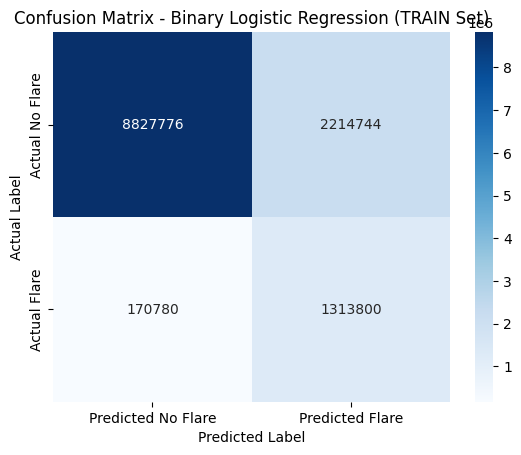


--- Metrics for: Binary Logistic Regression (VALIDATION Set) ---

Classification Report:
              precision    recall  f1-score   support

No Flare (0)       0.98      0.79      0.88    113100
   Flare (1)       0.36      0.88      0.51     15060

    accuracy                           0.80    128160
   macro avg       0.67      0.83      0.69    128160
weighted avg       0.91      0.80      0.83    128160

ROC AUC Score: 0.9177
Precision-Recall (PR) AUC Score: 0.6099
Balanced Accuracy: 0.8344
Matthews Corr. Coef (MCC): 0.4756


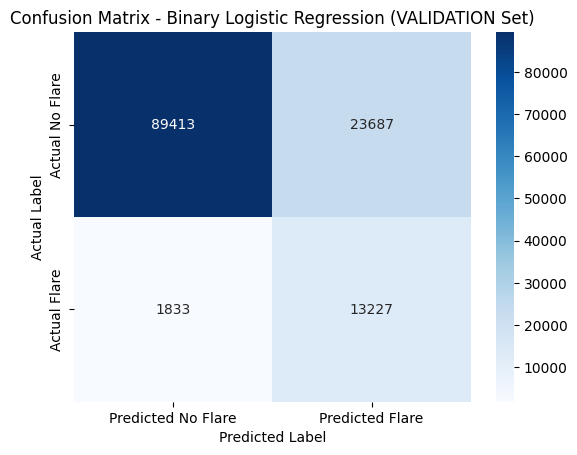

In [29]:
if RAPIDS_AVAILABLE:
    logreg_binary = cuLogReg(penalty='l2', max_iter=500, class_weight='balanced')
else:
    from dask_ml.linear_model import LogisticRegression
    logreg_binary = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=42, max_iter=100)

logreg_binary.fit(X_train_scaled_np if not RAPIDS_AVAILABLE else cp.asarray(X_train_scaled_np), y_train_binary_np if not RAPIDS_AVAILABLE else cp.asarray(y_train_binary_np))

evaluate_on_sets(logreg_binary, X_train_scaled, y_train_binary, X_dev_scaled, y_dev_binary, "Binary Logistic Regression")

## Baseline Model-2: Random Forest (with class weights)

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)



EVALUATING MODEL: Binary Random Forest
Predicting on training set...
Predicting on validation set...

--- Metrics for: Binary Random Forest (TRAIN Set) ---

Classification Report:
              precision    recall  f1-score   support

No Flare (0)       0.94      0.99      0.96  11042520
   Flare (1)       0.86      0.53      0.65   1484580

    accuracy                           0.93  12527100
   macro avg       0.90      0.76      0.81  12527100
weighted avg       0.93      0.93      0.93  12527100

ROC AUC Score: 0.9548
Precision-Recall (PR) AUC Score: 0.7984
Balanced Accuracy: 0.7570
Matthews Corr. Coef (MCC): 0.6421


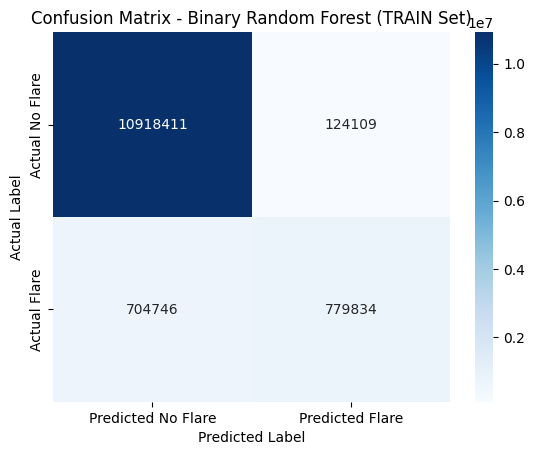


--- Metrics for: Binary Random Forest (VALIDATION Set) ---

Classification Report:
              precision    recall  f1-score   support

No Flare (0)       0.95      0.98      0.96    113100
   Flare (1)       0.83      0.58      0.68     15060

    accuracy                           0.94    128160
   macro avg       0.89      0.78      0.82    128160
weighted avg       0.93      0.94      0.93    128160

ROC AUC Score: 0.9493
Precision-Recall (PR) AUC Score: 0.7921
Balanced Accuracy: 0.7806
Matthews Corr. Coef (MCC): 0.6619


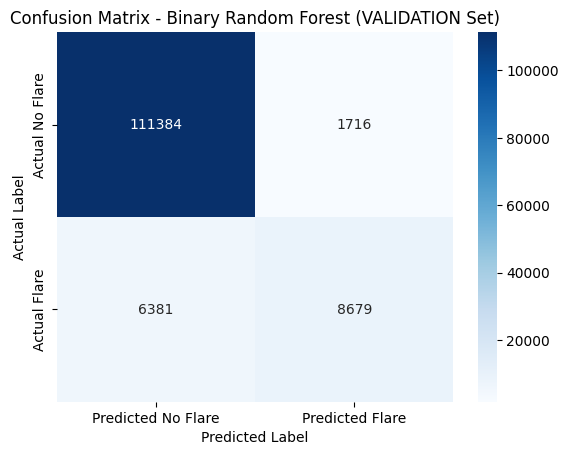

In [30]:
if RAPIDS_AVAILABLE:
    rf_binary = cuRF(n_estimators=500, max_depth=12, n_streams=8, random_state=42)
    rf_binary.fit(cp.asarray(X_train_scaled_np), cp.asarray(y_train_binary_np))
else:
    rf_binary = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    with joblib.parallel_backend('dask'):
        rf_binary.fit(X_train_scaled_np, y_train_binary_np)
    
evaluate_on_sets(rf_binary, X_train_scaled_np, y_train_binary_np, X_dev_scaled_np, y_dev_binary_np, "Binary Random Forest")

## Baseline Model-3: Binary Support Vector Machine (SVM)

In [ ]:
if RAPIDS_AVAILABLE:
    svm_binary = cuSVC(kernel='rbf', class_weight='balanced')
    svm_binary.fit(cp.asarray(X_train_scaled_np), cp.asarray(y_train_binary_np))
else:
    svm_binary = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
    svm_binary.fit(X_train_scaled_np, y_train_binary_np)
evaluate_on_sets(svm_binary, X_train_scaled_np, y_train_binary_np, X_dev_scaled_np, y_dev_binary_np, "Binary SVM")

# Baseline Models for Multiclass Classification

## Baseline Model-1: Multinomial Logistic Regression (Softmax Regression)

[2025-11-03 06:52:22.150] [CUML] [info] Unused keyword parameter: multi_class during cuML estimator initialization

EVALUATING MODEL: Multiclass Softmax Regression
Predicting on training set...
Predicting on validation set...

--- Metrics for: Multiclass Softmax Regression (TRAIN Set) ---

Classification Report:
              precision    recall  f1-score   support

    No Flare       0.92      0.98      0.95  11042520
     C-Class       0.56      0.34      0.42   1234740
     M-Class       0.66      0.14      0.23    227100
     X-Class       0.00      0.00      0.00     22740

    accuracy                           0.90  12527100
   macro avg       0.54      0.37      0.40  12527100
weighted avg       0.88      0.90      0.89  12527100

Weighted ROC AUC Score (One-vs-Rest): 0.9200
Balanced Accuracy: 0.3656
Matthews Corr. Coef (MCC): 0.4384


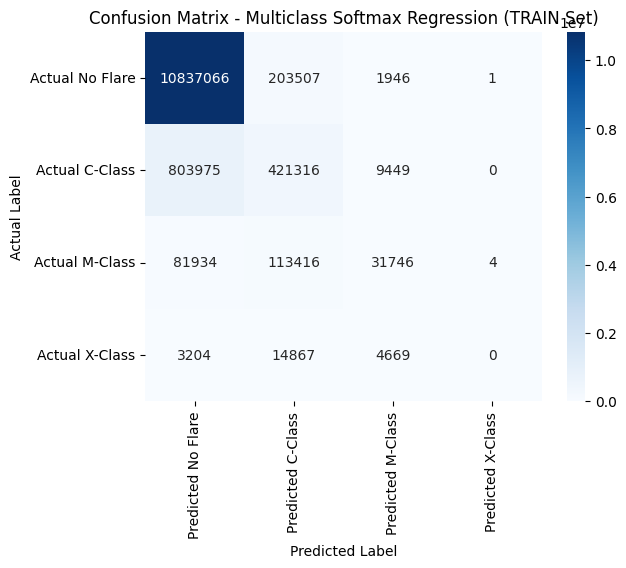


--- Metrics for: Multiclass Softmax Regression (VALIDATION Set) ---

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    No Flare       0.93      0.97      0.95    113100
     C-Class       0.56      0.39      0.46     12840
     M-Class       0.67      0.25      0.36      1980
     X-Class       0.00      0.00      0.00       240

    accuracy                           0.90    128160
   macro avg       0.54      0.40      0.44    128160
weighted avg       0.89      0.90      0.89    128160

Weighted ROC AUC Score (One-vs-Rest): 0.9190
Balanced Accuracy: 0.4044
Matthews Corr. Coef (MCC): 0.4682


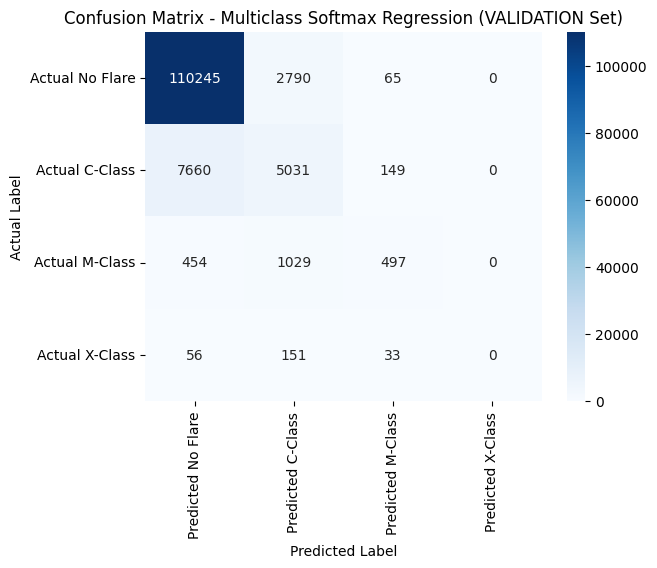

In [17]:
if RAPIDS_AVAILABLE:
    softmax_model = cuLogReg(multi_class='multinomial', penalty='l2', max_iter=1000, class_weight='balanced')
    softmax_model.fit(cp.asarray(X_train_scaled_np), cp.asarray(y_train_multiclass_np))
else:
    softmax_model = SklearnLogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', random_state=42, max_iter=1000)
    softmax_model.fit(X_train_scaled_np, y_train_multiclass_np)

evaluate_on_sets(softmax_model, X_train_scaled_np, y_train_multiclass_np, X_dev_scaled_np, y_dev_multiclass_np, "Multiclass Softmax Regression", problem_type='multiclass', class_names=class_names)

## Baseline Model-2: Multicalss Random Forest

/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)



EVALUATING MODEL: Multiclass Random Forest
Predicting on training set...
Predicting on validation set...

--- Metrics for: Multiclass Random Forest (TRAIN Set) ---

Classification Report:
              precision    recall  f1-score   support

    No Flare       0.93      0.99      0.96  11042520
     C-Class       0.79      0.42      0.55   1234740
     M-Class       0.87      0.43      0.58    227100
     X-Class       0.91      0.52      0.66     22740

    accuracy                           0.92  12527100
   macro avg       0.88      0.59      0.69  12527100
weighted avg       0.92      0.92      0.91  12527100

Weighted ROC AUC Score (One-vs-Rest): 0.9542
Balanced Accuracy: 0.5903
Matthews Corr. Coef (MCC): 0.5855


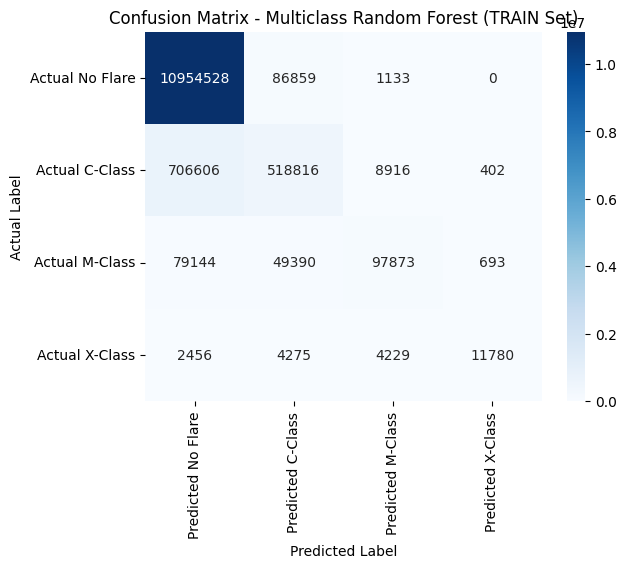


--- Metrics for: Multiclass Random Forest (VALIDATION Set) ---

Classification Report:
              precision    recall  f1-score   support

    No Flare       0.94      0.99      0.96    113100
     C-Class       0.77      0.48      0.59     12840
     M-Class       0.91      0.51      0.65      1980
     X-Class       0.98      0.50      0.66       240

    accuracy                           0.93    128160
   macro avg       0.90      0.62      0.72    128160
weighted avg       0.92      0.93      0.92    128160

Weighted ROC AUC Score (One-vs-Rest): 0.9486
Balanced Accuracy: 0.6184
Matthews Corr. Coef (MCC): 0.6190


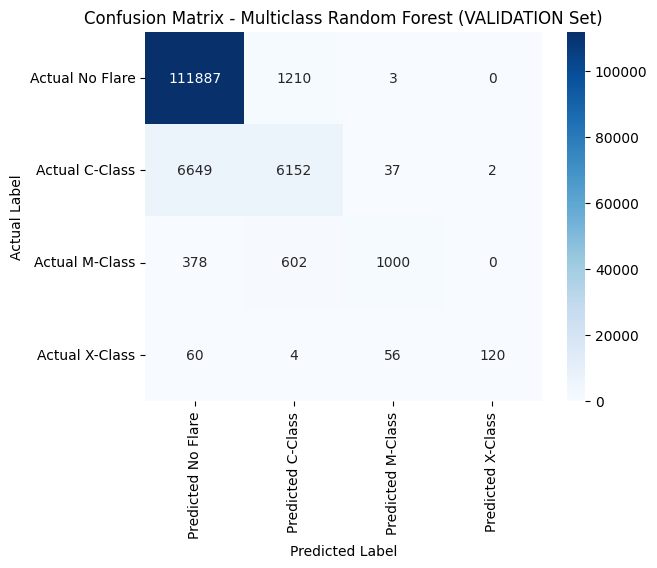

In [18]:
if RAPIDS_AVAILABLE:
    rf_multi = cuRF(n_estimators=500, max_depth=12, n_streams=8, random_state=42)
    rf_multi.fit(cp.asarray(X_train_scaled_np), cp.asarray(y_train_multiclass_np))
else:
    rf_multi = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    with joblib.parallel_backend('dask'):
        rf_multi.fit(X_train_scaled_np, y_train_multiclass_np)
evaluate_on_sets(rf_multi, X_train_scaled_np, y_train_multiclass_np, X_dev_scaled_np, y_dev_multiclass_np, "Multiclass Random Forest", problem_type='multiclass', class_names=class_names)

## Baseline Model-3: Multiclass Support Vector Machine (SVM)

In [ ]:
if RAPIDS_AVAILABLE:
    svm_multi = cuSVC(probability=True, kernel='rbf', class_weight='balanced')
    svm_multi.fit(cp.asarray(X_train_scaled_np), cp.asarray(y_train_multiclass_np))
else:
    svm_multi = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
    svm_multi.fit(X_train_scaled_np, y_train_multiclass_np)
evaluate_on_sets(svm_multi, X_train_scaled_np, y_train_multiclass_np, X_dev_scaled_np, y_dev_multiclass_np, "Multiclass SVM", problem_type='multiclass', class_names=class_names)

In [ ]:
CLIENT.close()